In [1]:
# MNIST test dataset
from tensorflow.keras.datasets import mnist

In [2]:
# import helper library
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import dataset
(trainx, trainy), (testx, testy) = mnist.load_data()

In [4]:
# seeing the shapes of imported dataset
trainx.shape, trainy.shape, testx.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

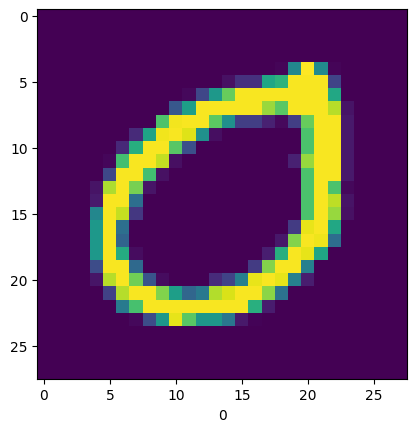

In [5]:
def choose_random_train():
    random_number = np.random.randint(0, 60000)
    sample_X = trainx[random_number]
    sample_y = trainy[random_number]
    return sample_X, sample_y, random_number

random_X, random_y, _ = choose_random_train()
plt.imshow(random_X)
plt.xlabel(random_y)

cursor = 0
def batch_generator_1000():
    global cursor
    print(cursor)
    x_batch = trainx[cursor:cursor+1000]
    y_batch = trainy[cursor:cursor+1000]
    cursor += 1000
    cursor %= 60000
    return x_batch, y_batch

# aax, aay = batch_generator_1000()
# aax.shape, aay.shape

### Making the layers

##### Layers
- Each layers maintains following associated datatypes:
    - Information types
        - name: Name of the layer
        - parameters_count: Number of parameters of the layer
    - Useful types
        - Depends on the type of layer:
            - Eg: For weights layer, it's the weight matrix
            - Eg: For bias layer, it's the bias vector
            - Eg: For the activation layer, it is nothing
        - They can be abstracted away for the user of the layer

- Each layer should have the following functions
    - Apply (input) -> output
        - It applies the layer's operation to it's input to give an output
    - Input gradient (output gradient, input value, output value) -> gradient values for input
        - It calculates the gradient for the input given the gradient values for the output.
        - It takes the output gradient values, it's input values and it's output values, if it saves the computations
    - Parameter gradient (output gradient, input value, output value) -> gradient values for parameters
        - It calculates the gradient for the parameters using the output gradients, input values and output values
        - If the layer doesn't have any parameters, it has to output zero (because we will sum the gradients, and we need something to sum it)
    - dummy gradient () -> a zero of shape of parameters
        - a zero gradient value of shape of the parameters
    - learn (parameter gradient, learning rate)
        - It modifies the parameter given the gradient of the parameters and the learning rate

In [6]:
# helper function
def expand_dims_and_transpose(x):
    return np.transpose(np.expand_dims(x, 0))
def expand_dims(x):
    return np.expand_dims(x, 0)

# layers
class Flattener:
    def __init__(self, shape):
        self.name = f"Flattener                 : {shape} to {np.prod(shape)}\n"
        self.param_count = 0

        self.from_shape = shape
    
    def apply(self, input_value):
        return np.ndarray.flatten(input_value)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return np.ndarray.reshape(output_gradient, self.from_shape)
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Scaler:
    def __init__(self, scale_factor):
        self.name = f"Scaler with scale factor {scale_factor}"
        self.param_count = 0

        self.scale_factor = scale_factor
    
    def apply(self, input_value):
        return self.scale_factor * input_value
    
    def input_gradient(self, output_gradient, input_value=None, output_value = None):
        return self.scale_factor * output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Weights:
    def __init__(self, input_size, output_size):
        self.name = f"Weights layer             : {input_size} to {output_size}"
        self.param_count = input_size * output_size
        
        # We create a transposed weights because input is a row vector
        self.weights = np.random.rand(input_size, output_size) - .5

    def apply(self, input_value):
        return np.matmul(input_value, self.weights)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        transposed_output_gradient = expand_dims_and_transpose(output_gradient)
        return np.transpose(np.matmul(self.weights, transposed_output_gradient))[0,:]
    
    def parameter_gradient(self, output_gradient, input_value, output_value=None):
        transposed_input = expand_dims_and_transpose(input_value)
        # print(np.shape(transposed_input), np.shape(output_gradient))
        return np.matmul(transposed_input, expand_dims(output_gradient))
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.weights))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.weights -= learning_rate * parameter_gradient_value

class Biases:
    def __init__(self, input_size):
        self.name = f"Biases layer              : {input_size}"
        self.param_count = input_size

        # We create a row vector of biases because input is a row vector
        self.biases = np.random.rand(input_size) - .5
    
    def apply(self, input_value):
        return input_value + self.biases
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.biases))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.biases -= learning_rate * parameter_gradient_value

class ReluActivation:
    def __init__(self):
        self.name = f"ReLU Activation\n"
        self.param_count = 0

        # we create a vectorized function for activaton
        self.activation_function = np.vectorize(lambda x: 0 if x < 0 else x)
        # similarly we create a vectorized function for gradient
        self.gradient_function = np.vectorize(lambda x: 0 if x < 0 else 1)
    
    def apply(self, input_value):
        return self.activation_function(input_value)
    
    def input_gradient(self, output_gradient, input_value, output_value=None):
        return np.multiply(output_gradient, self.gradient_function(input_value))
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class SoftmaxActivationOnlyWhenNeeded:
    def __init__(self, need=False):
        self.name = f"Softmax Activation, Activated:{need}\n"
        self.param_count = 0
        self.need = need
    
    def actual_apply(self, input_value):
        maximum = np.max(input_value)
        new_data = np.exp(input_value-maximum)
        denominator = np.sum(new_data)
        return new_data/denominator
        
    
    def apply(self, input_value):
        if self.need:
            return self.actual_apply(input_value)
        return input_value
    
    def actual_input_gradient(self, output_gradient, input_value, output_value=None):
        size = len(output_value)
        if output_value == None:
            output_value = self.actual_apply(input_value)
        magic_matrix = np.diag(output_value) - np.matmul(np.transpose(output_value), output_value)
        return np.matmul(output_gradient, magic_matrix)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        if self.need:
            return self.actual_input_gradient(output_gradient, input_value, output_value)
        return output_gradient
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

In [7]:
# dataset transformation
class OneHotEncoder:
    def __init__(self, input_size):
        self.name = "One hot encoder of size : {input_size}"
        self.size = input_size
    
    def __call__(self, number):
        output = np.zeros(self.size)
        output[number] = 1
        return output

class Identity:
    def __init__(self):
        self.name = "None"
    def __call__(self, x):
        return x

### Making the Loss Function
##### Loss function
- Each loss function has following data types
    - Name: Name of the loss function.

- Each loss function should implement the following methods
    - Apply(prediction, ground_truth) -> loss value
        - It calculates the required loss function.
    - Call(prediction, gournd_truth) -> loss value
        - It calls the apply function under the hood.
    - Prediction gradient(prediction, ground_truth) -> gradient values for output
        - It returns the gradient value for the loss wrt prediction value.
        - To calculate it, it is supplied with the prediction value and the ground truth.

In [8]:
def softmax_function(input_value):
    maximum = np.max(input_value)
    new_data = np.exp(input_value-maximum)
    denominator = np.sum(new_data)
    return new_data/denominator

class CrossEntropyLossFunctionFromLogits:
    def __init__(self):
        self.name = "Cross Entropy Loss Function from the logits"
        self.loss_function = softmax_function
    
    def apply(self, prediction, ground_truth):
        # ground_truth_class = np.argmax(ground_truth)
        # return -np.log(softmax_function(prediction)[ground_truth_class])

        softmax_output = softmax_function(prediction)
        return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))
    
    def __call__(self, prediction, ground_truth):
        return self.apply(prediction, ground_truth)
    
    def prediction_gradient(self, prediction, ground_truth):
        return np.sum(ground_truth)*softmax_function(prediction) - ground_truth


### Making the model
##### Sequential model
- Each sequential model should have following data types
    - Information types
        - Name: Name of the model
    - Useful types
        - Layers: A list of the sequential layers
        - Loss function : The function that defines the loss
        - Dataset transformation : The transformation that is applied to the output of the dataset

        - Cumulative parameter gradients for all layers
        - 
- Each sequential model should implement the following methods
    - Informational / debug
        - representation
    - Useful
        - inference (input) -> output
            - For simple inference
        - Reset gradient
            - To reset the parameter gradients for all layers
        - forward propagation (input) -> output
            - For simple layer by layer forward propagation
            - Saves the input to each layer
            - Saves the last output
            - Prepares for the back propagation
        - Back propagation (output gradients) ->
            - Layer by layer back propagation calculating the parameter gradients at each step, and back-propagating the intermediate gradients
            - Sums the parameter gradients
        - input gradients
            - To calculate the gradient of the input given the gradient of the output

    

In [9]:
class Sequential_Model:
    def __init__(self, layers, loss_function, name="Sequential Model",  dataset_transformation=Identity()):
        self.name = name

        self.layers = layers
        self.loss_function = loss_function
        self.dataset_transformation = dataset_transformation
        self.param_count = sum(layer.param_count for layer in layers)
        self.last_loss = 0
    
    def inference(self, input_value):
        last_output = input_value
        for layer in self.layers:
            last_output = layer.apply(last_output)
        return last_output

    def __call__(self, input_value):
        return self.inference(input_value)

    def reset_gradient(self):
        self.parameter_gradients = [layer.dummy_gradient() for layer in self.layers]
        self.last_loss = 0
    
    def forward_propagation(self, input_value):
        self.last_inputs = []

        last_input = input_value
        self.last_inputs.append(last_input)
        for layer in self.layers:
            last_input = layer.apply(last_input)
            self.last_inputs.append(last_input)
        return last_input
    
    def back_propagation(self, output_gradient):
        last_gradient = output_gradient
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            input_value = self.last_inputs[i]
            output_value = self.last_inputs[i+1]
            parameter_gradient = layer.parameter_gradient(last_gradient, input_value, output_value)

            # save cumulative gradients
            self.parameter_gradients[i] += parameter_gradient

            last_gradient = layer.input_gradient(last_gradient, input_value, output_value)
        return last_gradient
    
    def input_gradients(self, output_gradient):
        last = len(self.layers()) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            output_gradient = layer.input_gradient(output_gradient, self.last_inputs[i], self.last_inputs[i+1])
        return output_gradient
    
    def see_dataset_for_training(self, input_dataset, output_dataset):
        ground_truth = self.dataset_transformation(output_dataset)
        prediction = self.forward_propagation(input_dataset)
        prediction_gradient = self.loss_function.prediction_gradient(prediction, ground_truth)
        last_gradient = self.back_propagation(prediction_gradient)
        self.last_loss += self.loss_function(prediction, ground_truth)
        return last_gradient, prediction

    def make_model_learn(self, learning_rate):
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            layer.learn(self.parameter_gradients[i], learning_rate)
        pass

    def get_loss(self):
        return self.last_loss
    
    def __repr__(self):
        representation = f"{self.name}\n\n" 
        i = 0
        for layer in self.layers:
            i += 1
            representation += f"{i}. {layer.name}\n"
        representation += f"Total parameters = {self.param_count}\n"
        representation += f"Loss function = {self.loss_function.name}\n"
        return representation
        

        
            

In [10]:
# Building the model

MnistClassificationModel = Sequential_Model([
        Scaler(scale_factor=(1/255)),
        Flattener(shape=(28,28)),
    
        Weights(28*28, 400),
        Biases(400),
        ReluActivation(),
    
        Weights(400, 200),
        Biases(200),
        ReluActivation(),

        Weights(200, 100),
        Biases(100),
        ReluActivation(),
    
        Weights(100, 10),
        Biases(10),
    
        SoftmaxActivationOnlyWhenNeeded(),
    ],
    loss_function=CrossEntropyLossFunctionFromLogits(),
    name="Simple MNIST handwritten digit dataset classifier",
    dataset_transformation=OneHotEncoder(10)
)
# Reset cursor for training dataset if model is reinstiated
cursor = 0
losses = []
accuracy = []
# also reset the loss and accuracy, because when model is reinstated training is gone, and so are losses and the accuracy

print(MnistClassificationModel)
# output = MnistClassificationModel(random_X)
# print(output)
# print(softmax_function(output))


Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 400
4. Biases layer              : 400
5. ReLU Activation

6. Weights layer             : 400 to 200
7. Biases layer              : 200
8. ReLU Activation

9. Weights layer             : 200 to 100
10. Biases layer              : 100
11. ReLU Activation

12. Weights layer             : 100 to 10
13. Biases layer              : 10
14. Softmax Activation, Activated:False

Total parameters = 415310
Loss function = Cross Entropy Loss Function from the logits



Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 400
4. Biases layer              : 400
5. ReLU Activation

6. Weights layer             : 400 to 200
7. Biases layer              : 200
8. ReLU Activation

9. Weights layer             : 200 to 100
10. Biases layer              : 100
11. ReLU Activation

12. Weights layer             : 100 to 10
13. Biases layer              : 10
14. Softmax Activation, Activated:False

Total parameters = 415310
Loss function = Cross Entropy Loss Function from the logits



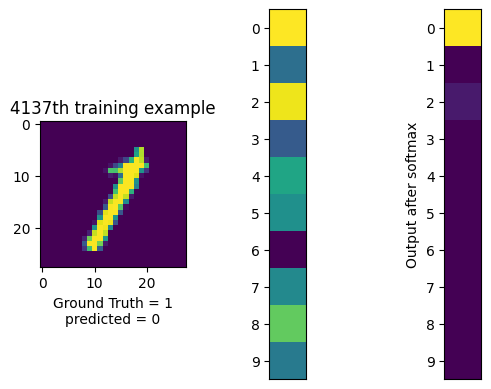

Logits output =  [ 70.62509237   2.13622471  68.01784521  -6.27153042  26.18058865
  16.95914642 -37.45171024  13.25913339  44.8448224    6.64461885]
Softmax output =  [9.31326541e-01 1.67789462e-30 6.86734590e-02 3.74388953e-34
 4.64621458e-20 4.59491824e-24 1.07632390e-47 1.13601102e-25
 5.92751946e-12 1.52312441e-28]
Loss value for this example =  -128014.62712490906


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_64105/2148852362.py:17: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))


In [11]:
def model_tester(print_outputs=False):
    rx, ry, n = choose_random_train()
    prediction = (MnistClassificationModel(rx))

    plt.subplot(1,3,1)
    plt.imshow(rx)
    plt.xlabel(f"Ground Truth = {ry}\npredicted = {np.argmax(prediction)}")
    plt.title(f"{n}th training example")

    plt.subplot(1,3,2)
    plt.imshow(np.reshape(prediction, (-1,1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(np.reshape(softmax_function(prediction), (-1, 1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    plt.ylabel("Output after softmax")

    plt.show()
    if print_outputs:
        print("Logits output = ", prediction)
        print("Softmax output = ", softmax_function(prediction))
        print("Loss value for this example = ", MnistClassificationModel.loss_function(prediction, ry))

print(MnistClassificationModel)
model_tester(True)


======= Epoch : 1 =======
Initial Loss = 4192.203136752332
50000
Loss after training = 3381.6261999140397


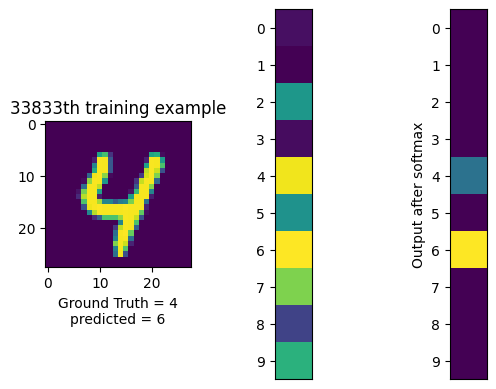

Logits output =  [-3.92465435 -5.99621741 19.79337649 -4.30187589 41.78160581 18.89416277
 42.75733022 33.41818384  3.74165737 25.09583698]
Softmax output =  [3.86665572e-21 4.87154928e-22 7.72583487e-11 2.65161381e-21
 2.73723497e-01 3.14356081e-11 7.26212643e-01 6.38445850e-05
 8.25605127e-18 1.55158207e-08]
Loss value for this example =  -65397.28114505489

======= Epoch : 2 =======
Initial Loss = 3381.6261999140397
51000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_64105/2148852362.py:17: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))


Loss after training = 2794.146770394237


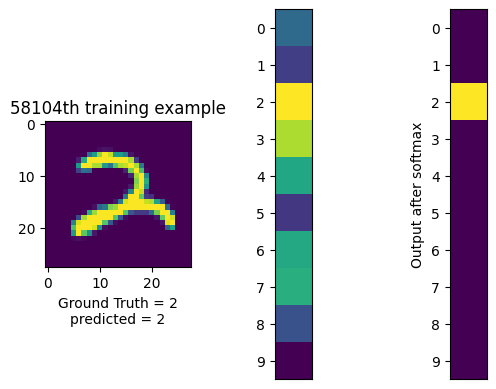

Logits output =  [  2.48654455  -5.69016158  35.60899077  29.33565471  15.29013919
  -6.92731772  15.52306394  16.89934483  -2.2477504  -15.09268587]
Softmax output =  [4.11420659e-15 1.15661213e-18 9.98117613e-01 1.88237646e-03
 1.49560392e-09 3.35658507e-19 1.88788063e-09 7.47628294e-09
 3.61582933e-17 9.54384394e-23]
Loss value for this example =  -68814.42344305434

======= Epoch : 3 =======
Initial Loss = 2794.146770394237
52000
Loss after training = 3531.9461997178264


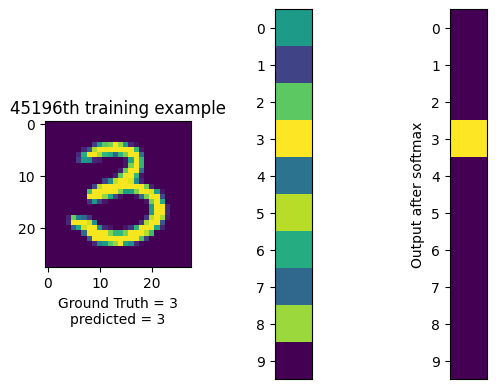

Logits output =  [  6.34743067 -17.85007015  21.02798043  39.11579283  -5.34958627
  31.48726884  11.75359307  -8.52215125  28.27264287 -32.68630642]
Softmax output =  [5.87031580e-15 1.81894842e-25 1.39425824e-08 9.99494326e-01
 4.88327920e-20 4.86132281e-04 1.30775975e-12 2.04589854e-21
 1.95281067e-05 6.55427777e-32]
Loss value for this example =  -80344.29709259224

======= Epoch : 4 =======
Initial Loss = 3531.9461997178264
53000
Loss after training = 2861.4378386338653


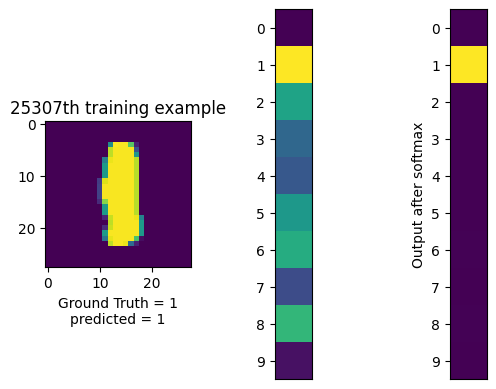

Logits output =  [-0.93627218 13.61413067  7.51984635  3.90269003  3.06616618  6.82052555
  8.08069942  2.47378828  8.68035416 -0.28854398]
Softmax output =  [4.72641862e-07 9.85579925e-01 2.22319624e-03 5.97127084e-05
 2.58683709e-05 1.10475667e-03 3.89541014e-03 1.43054862e-05
 7.09544987e-03 9.03310307e-07]
Loss value for this example =  -21255.059047408915

======= Epoch : 5 =======
Initial Loss = 2861.4378386338653
54000
Loss after training = 3121.233831817463

======= Epoch : 6 =======
Initial Loss = 3121.233831817463
55000
Loss after training = 2536.046911045882


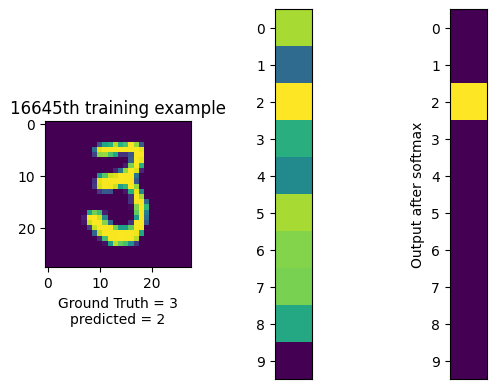

Logits output =  [ 10.14231525 -12.56371583  15.82832282  -0.49744487  -7.22727033
  10.04485121   7.62615674   7.02523857  -1.55188323 -27.92473052]
Softmax output =  [3.36987556e-03 4.63991322e-13 9.93151661e-01 8.06909357e-08
 9.64048072e-11 3.05693192e-03 2.72182441e-04 1.49239801e-04
 2.81117573e-08 9.89249736e-20]
Loss value for this example =  -39834.87715748317

======= Epoch : 7 =======
Initial Loss = 2536.046911045882
56000
Loss after training = 2489.67491080041


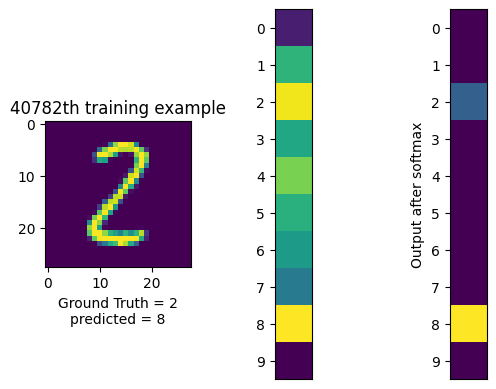

Logits output =  [-26.0616892    5.77166926  24.25822905   2.86285272  14.20316285
   4.90844161  -0.12008356  -7.52223501  25.43856154 -30.74864454]
Softmax output =  [3.29144528e-23 2.20008044e-09 2.34990045e-01 1.19992910e-10
 1.00969383e-05 9.27990555e-10 6.07691025e-12 3.70654511e-15
 7.64999854e-01 3.03296779e-25]
Loss value for this example =  -61994.83334515265

======= Epoch : 8 =======
Initial Loss = 2489.67491080041
57000
Loss after training = 2979.4259485779066


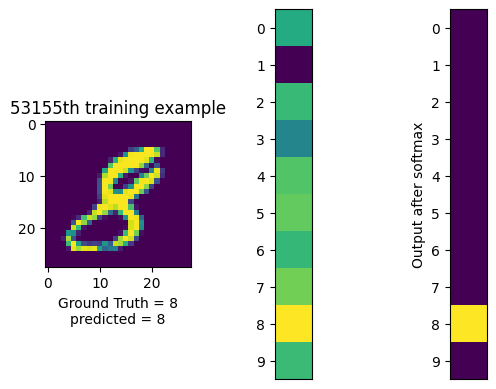

Logits output =  [  3.95224949 -23.63444271   6.7710124   -3.10208348   9.0704889
  10.58608793   6.27484371  11.79595368  21.32839079   7.03227602]
Softmax output =  [2.84180443e-08 2.97061241e-20 4.76175846e-07 2.45434893e-11
 4.74697908e-06 2.16089474e-05 2.89923914e-07 7.24555460e-05
 9.99899776e-01 6.18347647e-07]
Loss value for this example =  -40476.11310750169

======= Epoch : 9 =======
Initial Loss = 2979.4259485779066
58000
Loss after training = 2513.3206060835164

======= Epoch : 10 =======
Initial Loss = 2513.3206060835164
59000
Loss after training = 2426.0321284924967


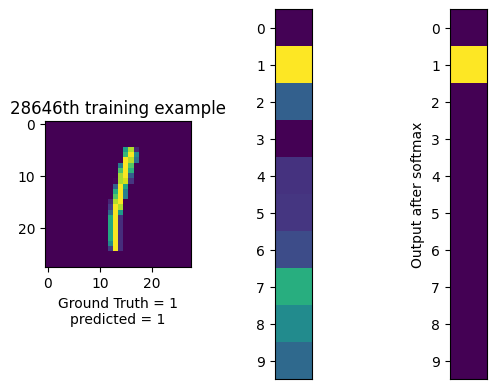

Logits output =  [-6.90164359 27.25195331  3.35997354 -7.16231157 -2.08349794 -1.66817251
  0.85683334 14.38612086  9.48325183  4.53652872]
Softmax output =  [1.46987431e-15 9.99997396e-01 4.20575428e-11 1.13259211e-15
 1.81875528e-13 2.75516626e-13 3.44146945e-12 2.58487075e-06
 1.91933096e-08 1.36400298e-10]
Loss value for this example =  -58767.43339459071


In [19]:
examples = 10
epochs = 10
last_epoch = -1
learning_rate = 0.01
for epoch in range(epochs):
    print(f"\n======= Epoch : {epoch+1} =======")
    print(f"Initial Loss = {MnistClassificationModel.get_loss()}")
    MnistClassificationModel.reset_gradient()
    batchx, batchy = batch_generator_1000()
    correct = 0
    incorrect = 0
    for tx, ty in zip(batchx, batchy):
        _, prediction = MnistClassificationModel.see_dataset_for_training(tx, ty)
        predicted_class = np.argmax(prediction)
        if predicted_class == ty:
            correct += 1
        else:
            incorrect += 1
    accuracy.append((correct)/(correct+incorrect))
        
    MnistClassificationModel.make_model_learn(learning_rate/1000)
    print(f"Loss after training = {MnistClassificationModel.get_loss()}")
    losses.append(MnistClassificationModel.get_loss())

    log_epoch = np.floor(np.log(epoch + 1)/np.log(epochs)*examples)
    if log_epoch != last_epoch:
        model_tester(print_outputs=True)
    last_epoch = log_epoch


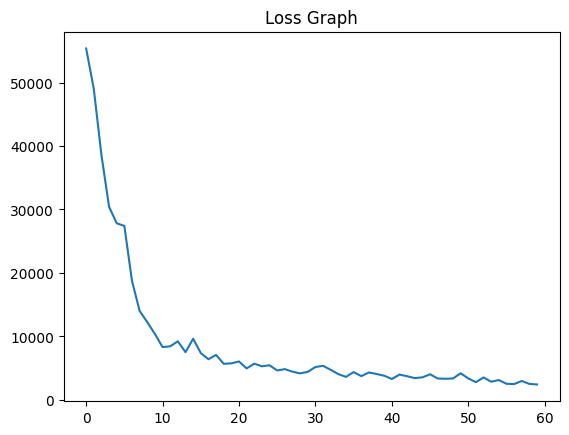

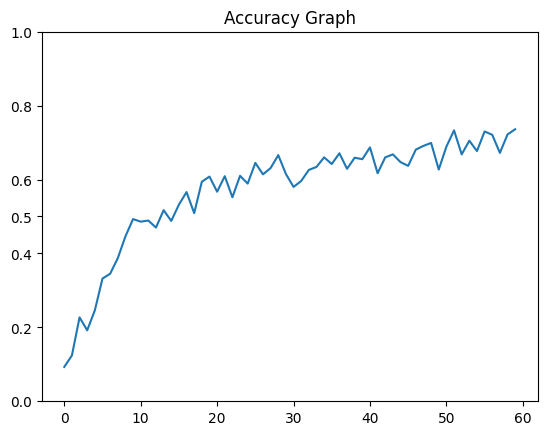

In [20]:
plt.plot(losses)
plt.title("Loss Graph")
plt.savefig("Loss-graph.png")
plt.show()

plt.plot(accuracy)
plt.yticks([0, .2, .4, .5, .6, .8, 1.])
plt.title("Accuracy Graph")
plt.savefig("Accuracy-graph.png")
plt.show()

array([[-11.68286452],
       [-19.97537119],
       [ -9.06712985],
       [ -8.16395547],
       [ 38.68915965],
       [  9.70137614],
       [ 37.33374975],
       [ 21.79119931],
       [ -7.21986703],
       [ 52.18931799]])

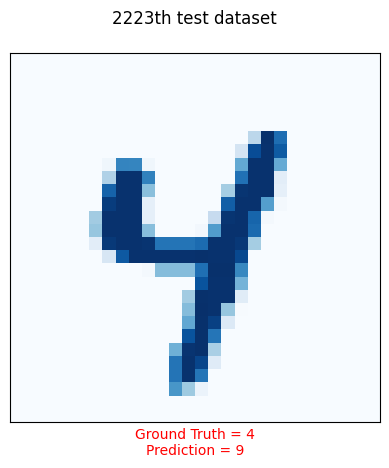

In [14]:
def choose_random_test():
    limit = len(testy)
    random_number = np.random.randint(0, limit)
    sample_X = testx[random_number]
    sample_y = testy[random_number]
    return sample_X, sample_y, random_number
    
def choose_random_and_test_model(log_output=True):
    xx, yy, n = choose_random_test()
    prediction = MnistClassificationModel(xx)
    prediction_number = np.argmax(prediction)

    correct = prediction_number == yy
    colour = 'blue' if correct else 'red'
    plt.imshow(xx, cmap="Blues")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Ground Truth = {yy}\nPrediction = {prediction_number}", color=colour)
    plt.title(f"{n}th test dataset\n")
    return np.reshape(prediction, (-1,1))
    
choose_random_and_test_model() 

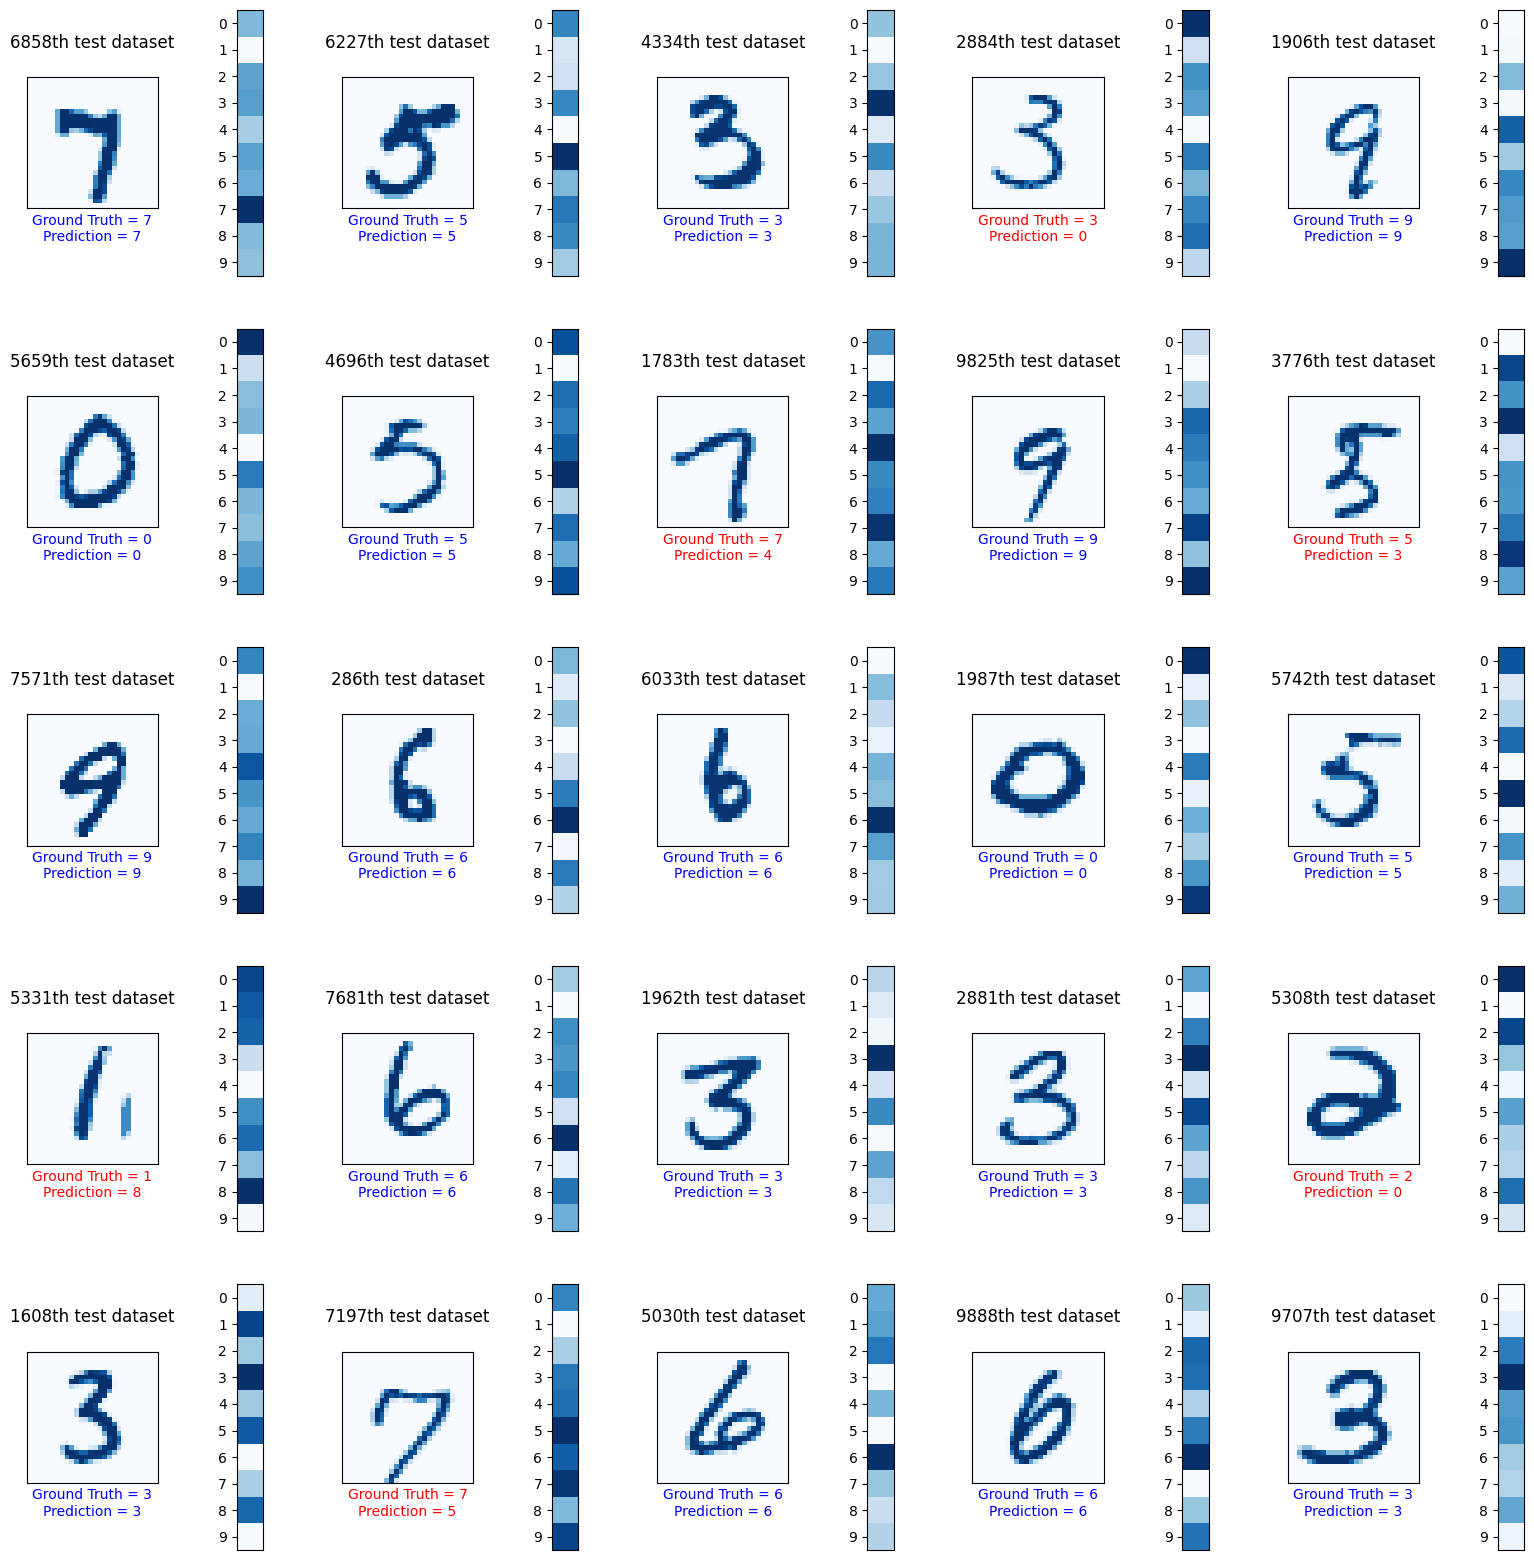

In [21]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,10, i*2+1)
    prediction = choose_random_and_test_model()

    plt.subplot(5, 10, i*2+2)
    plt.imshow(prediction, cmap='Blues')
    plt.yticks(np.arange(10))
    plt.xticks([])

plt.savefig("Output.png")
    